In [56]:
import json
from pathlib import Path
from collections import Counter
import pandas as pd
from plotnine import *
import magicsoup as ms
import e1_co2_fixing.src.util as util

theme_set(theme_minimal())
THIS_DIR = Path(".") / "e1_co2_fixing"
RUNS_DIR = THIS_DIR / "runs"

world = ms.World.from_file(rundir=RUNS_DIR)

In [80]:
util.load_cells(world=world, label="2023-07-23_14-51_1:-1", runsdir=RUNS_DIR)

all_cell_prots = []
for cell_i in range(world.n_cells):
    cell = world.get_cell(by_idx=cell_i)
    all_cell_prots.append([str(d) for d in cell.proteome])

In [84]:
def dom_in_prot(dom: str, prot: str) -> bool:
    if " <-> " not in dom:
        return dom in prot
    lft, rgt = dom.split(" <-> ")
    fwd = lft + " <-> " + rgt
    bwd = rgt + " <-> " + lft
    return fwd in prot or bwd in prot

def dom_in_proteome(dom: str, prots: list[str]) -> bool:
    return any(dom_in_prot(dom=dom, prot=d) for d in prots)

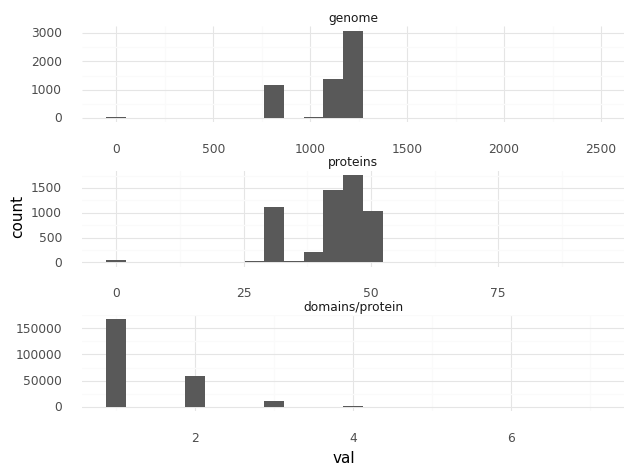

<ggplot: (8770219719470)>

In [53]:
records = []
for cell_i, (prots, genome) in enumerate(zip(all_cell_prots, world.genomes)):
    prots = [d for d in prots if len(d) > 0]
    records.append({"cell": cell_i, "var": "genome", "val": len(genome)})
    records.append({"cell": cell_i, "var": "proteins", "val": len(prots)})
    if len(prots) > 0:
        for prot in prots:
            doms = len(prot.split("|"))
            records.append({"cell": cell_i, "var": "domains/protein", "val": doms})

df = pd.DataFrame.from_records(records)
df["var"] = pd.Categorical(df["var"], categories=["genome", "proteins", "domains/protein"])

(ggplot(df)
    + geom_histogram(aes(x="val"), bins=25)
    + facet_wrap("var", scales="free", ncol=1)
    + theme(figure_size=(7, 5), subplots_adjust={'hspace': 0.5}))

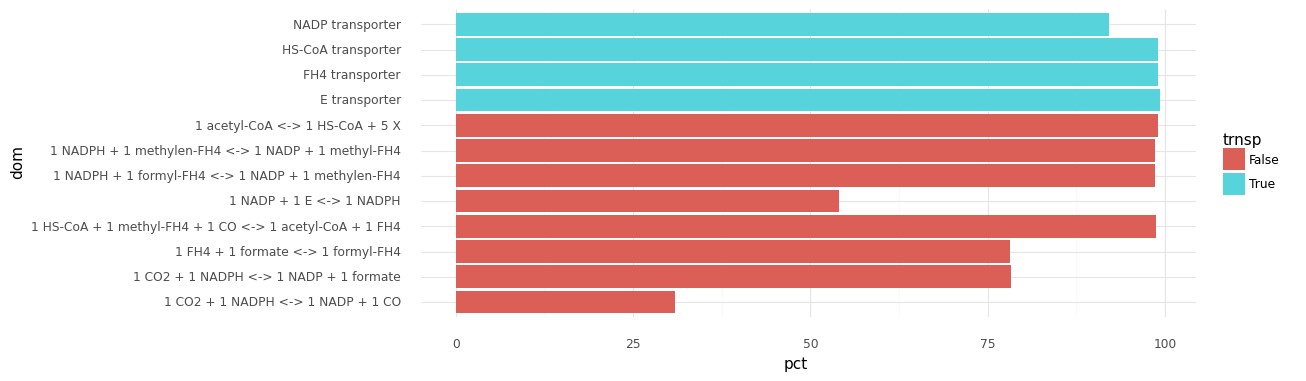

<ggplot: (8770264114864)>

In [96]:
expected_doms = [
    "E transporter",
    "NADP transporter",
    "HS-CoA transporter",
    "FH4 transporter",
    "1 NADP + 1 E <-> 1 NADPH",
    "1 CO2 + 1 NADPH <-> 1 NADP + 1 CO",
    "1 CO2 + 1 NADPH <-> 1 NADP + 1 formate",
    "1 FH4 + 1 formate <-> 1 formyl-FH4",
    "1 NADPH + 1 methylen-FH4 <-> 1 NADP + 1 methyl-FH4",
    "1 NADPH + 1 formyl-FH4 <-> 1 NADP + 1 methylen-FH4",
    "1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4",
    "1 acetyl-CoA <-> 1 HS-CoA + 5 X",
]

dom_cnts = {d: 0 for d in expected_doms}
for prots in all_cell_prots:
    for dom in expected_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df["trnsp"] = ["transporter" in d for d in df["dom"]]

(ggplot(df)
    + geom_col(aes(y="pct", x="dom", fill="trnsp"))
    + coord_flip()
    + theme(figure_size=(10, 4)))

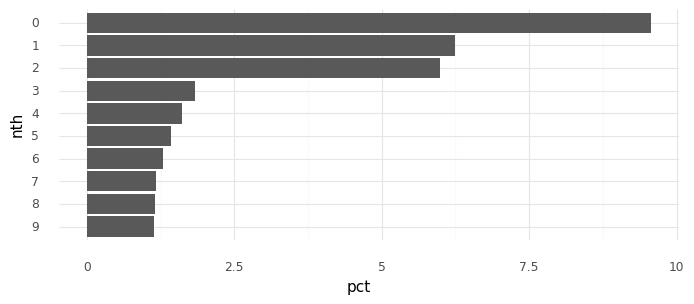

<ggplot: (8770263820646)>

In [72]:
genome_counts = Counter(world.genomes)
n = world.n_cells
k = 10

records = [{"nth": i, "pct": d / n * 100} for i, (_, d) in enumerate(genome_counts.most_common(n=k))]
df = pd.DataFrame.from_records(records)
df["nth"] = pd.Categorical(df["nth"], categories=reversed(list(range(k))))

(ggplot(df)
    + geom_col(aes(y="pct", x="nth"))
    + coord_flip()
    + theme(figure_size=(8, 3)))

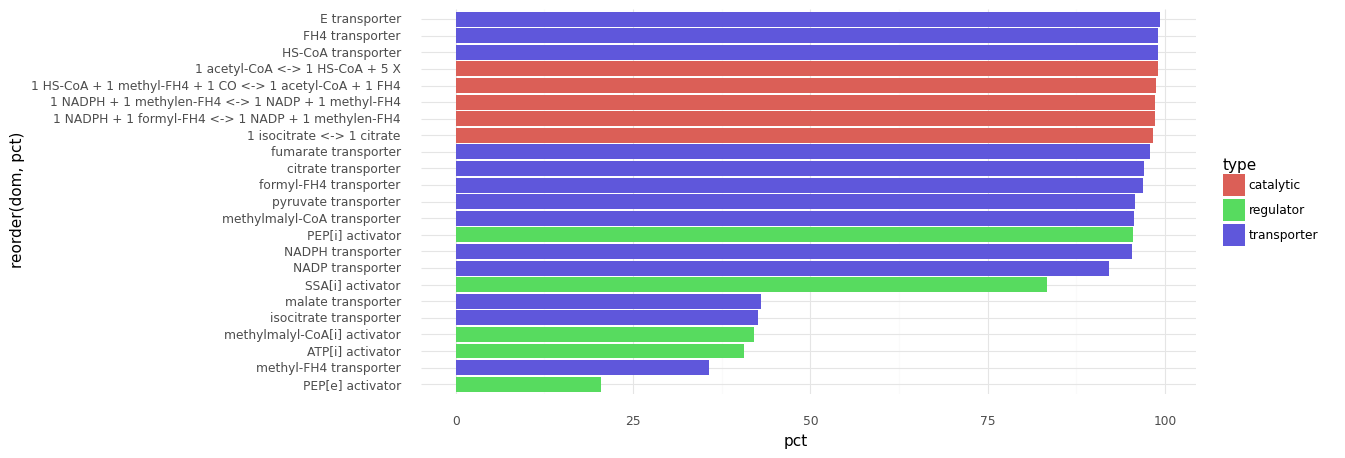

<ggplot: (8770264162752)>

In [91]:
n0_genome = genome_counts.most_common(n=1)[0][0]
n0_i = world.genomes.index(n0_genome)

n0_prots = set(d for d in all_cell_prots[n0_i] if len(d) > 0)
n0_doms = set(dd.strip() for d in n0_prots for dd in d.split("|"))

dom_cnts = {d: 0 for d in n0_doms}
for prots in all_cell_prots:
    for dom in n0_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "regulator"
df.loc[["transporter" in d for d in df["dom"]], "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"

(ggplot(df.sort_values("pct"))
    + geom_col(aes(y="pct", x="reorder(dom, pct)", fill="type"))
    + coord_flip()
    + theme(figure_size=(10, 5)))

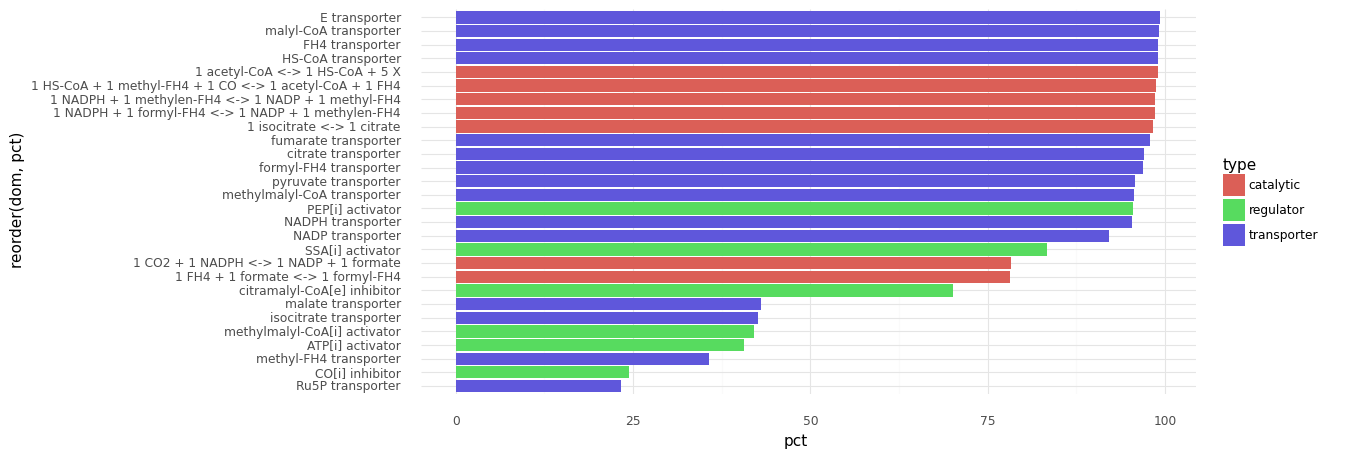

<ggplot: (8770263905653)>

In [93]:
n0_genome = genome_counts.most_common(n=2)[1][0]
n0_i = world.genomes.index(n0_genome)

n0_prots = set(d for d in all_cell_prots[n0_i] if len(d) > 0)
n0_doms = set(dd.strip() for d in n0_prots for dd in d.split("|"))

dom_cnts = {d: 0 for d in n0_doms}
for prots in all_cell_prots:
    for dom in n0_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "regulator"
df.loc[["transporter" in d for d in df["dom"]], "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"

(ggplot(df.sort_values("pct"))
    + geom_col(aes(y="pct", x="reorder(dom, pct)", fill="type"))
    + coord_flip()
    + theme(figure_size=(10, 5)))

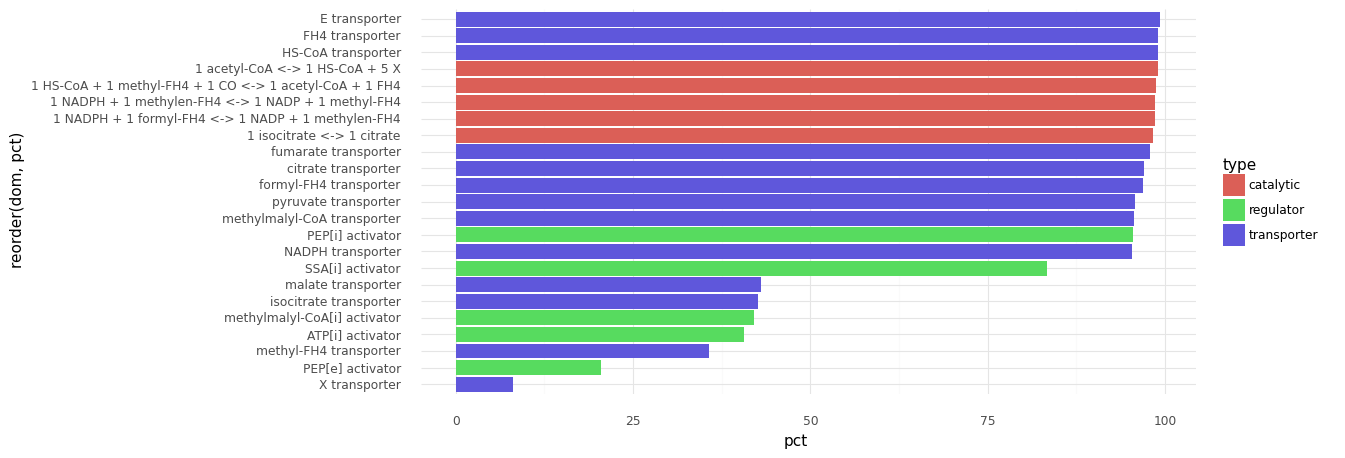

<ggplot: (8770264349252)>

In [94]:
n0_genome = genome_counts.most_common(n=3)[2][0]
n0_i = world.genomes.index(n0_genome)

n0_prots = set(d for d in all_cell_prots[n0_i] if len(d) > 0)
n0_doms = set(dd.strip() for d in n0_prots for dd in d.split("|"))

dom_cnts = {d: 0 for d in n0_doms}
for prots in all_cell_prots:
    for dom in n0_doms:
        if dom_in_proteome(dom=dom, prots=prots):
            dom_cnts[dom] += 1

n = len(all_cell_prots)
df = pd.DataFrame.from_records([{"dom": k, "pct": d / n * 100} for k, d in dom_cnts.items()])
df.loc[:, "type"] = "regulator"
df.loc[["transporter" in d for d in df["dom"]], "type"] = "transporter"
df.loc[["<->" in d for d in df["dom"]], "type"] = "catalytic"

(ggplot(df.sort_values("pct"))
    + geom_col(aes(y="pct", x="reorder(dom, pct)", fill="type"))
    + coord_flip()
    + theme(figure_size=(10, 5)))

In [95]:
# TODO: mit den domain overlaps kann ich mir eine similarity herstellen (k von n domains oder k von n proteins)
#       damit kann ich Zellen einfärben und mir auf Karte anschauen

# die top 3 genomes können alleine gar nicht überleben
# die brauchen eine kleinere subpopulation an Zellen die "1 CO2 + 1 NADPH <-> 1 NADP + 1 CO"
# hat um CO herzustellen (CO diffundiert ja dann überall rum)

{'1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 '1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | E transporter | 1 NADP + 1 E <-> 1 NADPH',
 '1 CO2 + 1 NADPH <-> 1 NADP + 1 CO | oxalacetate[e] activator',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4 | 1 NADPH + 1 formyl-FH4 <-> 1 NADP + 1 methylen-FH4',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4 | formate transporter',
 '1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4 | fumarate transporter',
 '1 NADP + 1 CO <-> 1 CO2 + 1 NADPH',
 '1 citrate <-> 1 isocitrate | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 '1 isocitrate <-> 1 citrate | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 'E transporter | 1 NADP + 1 CO <-> 1 CO2 + 1 NADPH',
 'FH4 transporter | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 FH4',
 'FH4 transporter | 1 HS-CoA + 1 methyl-FH4 + 1 CO <-> 1 acetyl-CoA + 1 